In [1]:
%%writefile multilabel_data_h5.py
import h5py,os,pandas as pd,numpy as np
import seaborn as sn,pylab as pl
from IPython.display import display
from tensorflow.keras.preprocessing \
import image as tkimg

def images2array(files_path,img_size,
                 preprocess=False,grayscale=False):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if preprocess:
            img=tkimg.load_img(
                img_path,grayscale=grayscale)
            img=tkimg.img_to_array(img)
            img=tkimg.smart_resize(
                img,(img_size,img_size))
        else:
            img=tkimg.load_img(
                img_path,target_size=(img_size,img_size))
            img=tkimg.img_to_array(img)
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),
                    dtype='float32')

def labels2array(files_path):
    files_list=sorted(os.listdir(files_path))
    files_split=np.array([el.split('_') 
                          for el in files_list])
    num_labels=files_split.shape[1]-1
    labels=[files_split[:,i] 
            for i in range(num_labels)]
    labels=np.array(labels).astype('int32')
    for i in range(num_labels):
        label_set=list(set(labels[i]))
        replace_dict=\
        dict(zip(label_set,
                 list(range(len(label_set)))))
        labels[i]=[replace_dict.get(x,x) 
                   for x in labels[i]]
    return labels

def data2h5file(h5file,files_path,img_size,names,
                preprocess=False,grayscale=False):
    images=images2array(files_path,img_size,
                        preprocess,grayscale)
    labels=labels2array(files_path)
    maxlen=max([max([len(n) for n in names[i]])
                for i in range(len(names))])
    names=[np.array([np.string_(name.encode('utf-8')) 
                     for name in names[i]],
                    dtype='S%d'%maxlen)
           for i in range(len(names))]
    with h5py.File(h5file,'w') as f:
        f.create_dataset('images',data=images,
                         compression="gzip")
        f.create_dataset('labels',data=labels,
                         compression="gzip")
        for i in range(len(names)): 
            f.create_dataset('names%d'%(i+1),
                             data=names[i],
                             dtype='S%d'%maxlen,
                             compression="gzip")
        f.close()
    print('\nfile size: %s'%list(os.stat(h5file))[6])
    
def h5file2data(h5file,cmap='Pastel1'):
    with h5py.File(h5file,'r') as f:
        keys=list(f.keys())
        print('file keys: '+', '.join(keys))
        images=np.array(f[keys[0]])
        labels=np.array(f[keys[1]])
        names=[[el.decode('utf-8') 
                for el in f[keys[i]]]
               for i in range(2,len(keys))]
        f.close()
    N=images.shape[0]; n=int(.1*N)
    shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    images=images[shuffle_ids]
    labels=np.array([labels[i][shuffle_ids]
                     for i in range(labels.shape[0])])
    x_test,x_valid,x_train=\
    images[:n],images[n:2*n],images[2*n:]
    y_test,y_valid,y_train=\
    labels[:,:n],labels[:,n:2*n],labels[:,2*n:]
    print('data outputs: ')
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type'])
    display(df)
    print('distribution of labels: ')
    idx=['labels %d'%(i+1) 
         for i in range(labels.shape[0])]
    df=pd.DataFrame(labels,index=idx).T
    for i in range(labels.shape[0]):
        df['name %d'%(i+1)]=\
        [names[i][l] for l in labels[i]]
    fig=pl.figure(figsize=(10,10))    
    for i in range(labels.shape[0]):
        ax=fig.add_subplot(labels.shape[0],1,i+1)
        sn.countplot(x='name %s'%(i+1),data=df,
                     palette=cmap,alpha=.5,ax=ax)
    pl.show()       
    return [names,x_train,x_valid,x_test,
            y_train,y_valid,y_test,
            y_train,y_valid,y_test]

def display_images(images,labels,names,n):
    fig=pl.figure(figsize=(10,n))
    randch=np.random.choice(
        images.shape[0],size=n,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(
            n//3,3,i+1,xticks=[],yticks=[])
        ax.imshow(images[idx])
        label=[labels[:,idx]]
        name=[names[i][labels[i][idx]]
              for i in range(labels.shape[0])]
        ax.set_title('{} \n {}'\
                     .format(str(label),str(name)),
                     fontsize=10)
    pl.show()

Writing multilabel_data_h5.py


In [2]:
%run multilabel_data_h5.py

In [3]:
%run ../input/python-recipes/dhtml.py
#%run ../input/python-recipes/multilabel_data_h5.py
dhtml('Data Type #3 => Multi-Labeled Photo Files (PNG)')

In [4]:
files_path1='../input/classification-of-handwritten-letters/'+\
            'zip_letters/letters/'
img_size1=32
h5file1='Letters'+str(img_size1)+'.h5'
names1=[['lowercase','uppercase'],
        [s for s in 
         u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'],
        ['single-colored paper','striped paper',
         'squared paper','graph paper']]

In [5]:
data2h5file(h5file1,files_path1,img_size1,names1,
            preprocess=True,grayscale=False)

=>=>=>=>=>=>=>=>=>=>
file size: 46120456


file keys: images, labels, names1, names2, names3
data outputs: 


,train,valid,test
image shape,"(11352, 32, 32, 3)","(1419, 32, 32, 3)","(1419, 32, 32, 3)"
image type,float32,float32,float32
label shape,"(3, 11352)","(3, 1419)","(3, 1419)"
label type,int32,int32,int32


distribution of labels: 


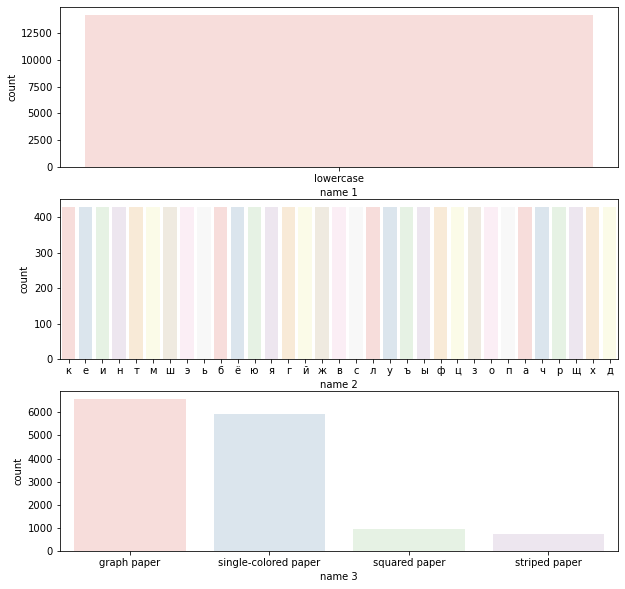

In [6]:
[names1,x_train1,x_valid1,x_test1,
 y_train1,y_valid1,y_test1,
 y_train1,y_valid1,y_test1]=\
h5file2data(h5file1,cmap='Pastel1')

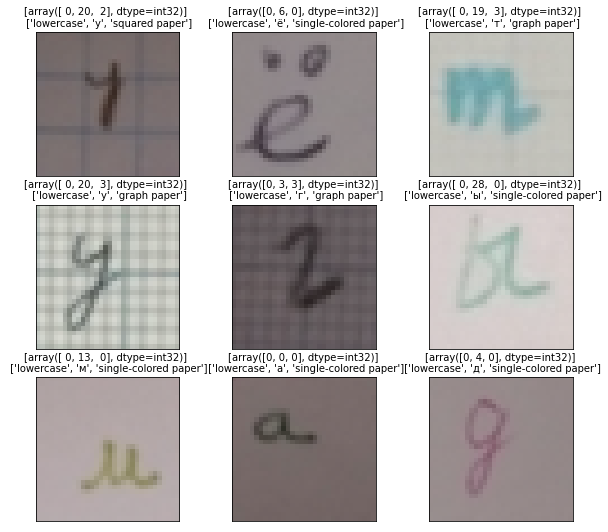

In [7]:
display_images(x_train1,y_train1,names1,9)

In [8]:
dhtml('Data Type #4 => Multi-Labeled Draw Files (PNG)')

In [9]:
files_path2='../input/art-pictogram/'+\
            'pictograms/'
img_size2=64
h5file2='Pictograms'+str(img_size2)+'.h5'
names2=[['pictogram','contour','sketch'],
        ['flower','bird','butterfly','tree',
         'plane','crane','dog','horse','deer',
         'truck','car','cat','frog',
         'ship','fish','house']]

In [10]:
data2h5file(h5file2,files_path2,img_size2,names2,
            preprocess=False,grayscale=False)

=>=>=>=>=>=>=>=>=>=>=>
file size: 33321624


file keys: images, labels, names1, names2
data outputs: 


,train,valid,test
image shape,"(2837, 64, 64, 3)","(354, 64, 64, 3)","(354, 64, 64, 3)"
image type,float32,float32,float32
label shape,"(2, 2837)","(2, 354)","(2, 354)"
label type,int32,int32,int32


distribution of labels: 


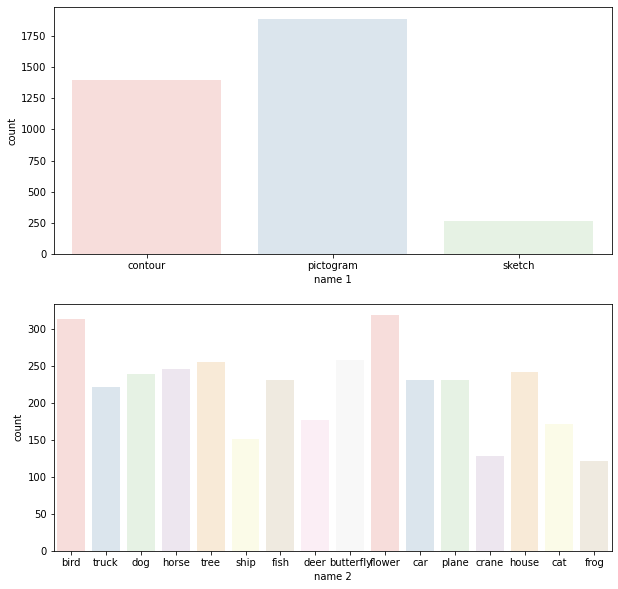

In [11]:
[names2,x_train2,x_valid2,x_test2,
 y_train2,y_valid2,y_test2,
 y_train2,y_valid2,y_test2]=\
h5file2data(h5file2,cmap='Pastel1')

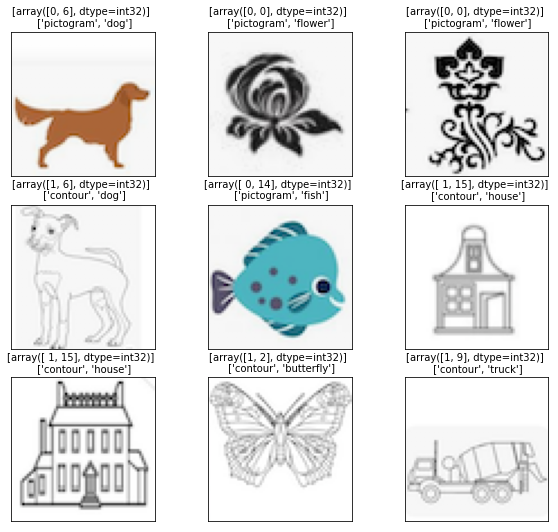

In [12]:
display_images(x_train2,y_train2,names2,9)

In [13]:
dhtml('In Progress')